In [245]:
import gc # сборщик мусора
import datetime

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as img
import seaborn as sns
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from sklearn.preprocessing import StandardScaler, RobustScaler
%matplotlib inline

# Ипользуемые функции

In [1242]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [671]:
def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

In [672]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [673]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

In [674]:
def nan_analize(X):
    nan_df = (X.isna().sum() / X.shape[0]).reset_index()
    nan_df.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(nan_df['feature'], nan_df['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

# Загрузка данных

In [1367]:
df = pd.read_csv('../kaggle/realestatepriceprediction/train.csv')

X = df.drop('Price', axis=1)
y = df[['Id', 'Price']]

X_final = pd.read_csv('../kaggle/realestatepriceprediction/test.csv')

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)
y.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


16893

In [1368]:
final_index_list = X_final.index
final_index_list

Int64Index([  725, 15856,  5480, 15664, 14275,  7633, 13329,  5502,  4220,
            11538,
            ...
            15706,  2105,  7220, 14562,  6836,  8180,  4695,  5783,  4780,
            12504],
           dtype='int64', name='Id', length=5000)

In [1369]:
X.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2'],
      dtype='object')

In [1370]:
X = reduce_mem_usage(X)

Memory usage of dataframe is 1.45 MB
Memory usage after optimization is: 0.51 MB
Decreased by 65.1%


In [1371]:
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.24 MB
Decreased by 66.4%


# EDA

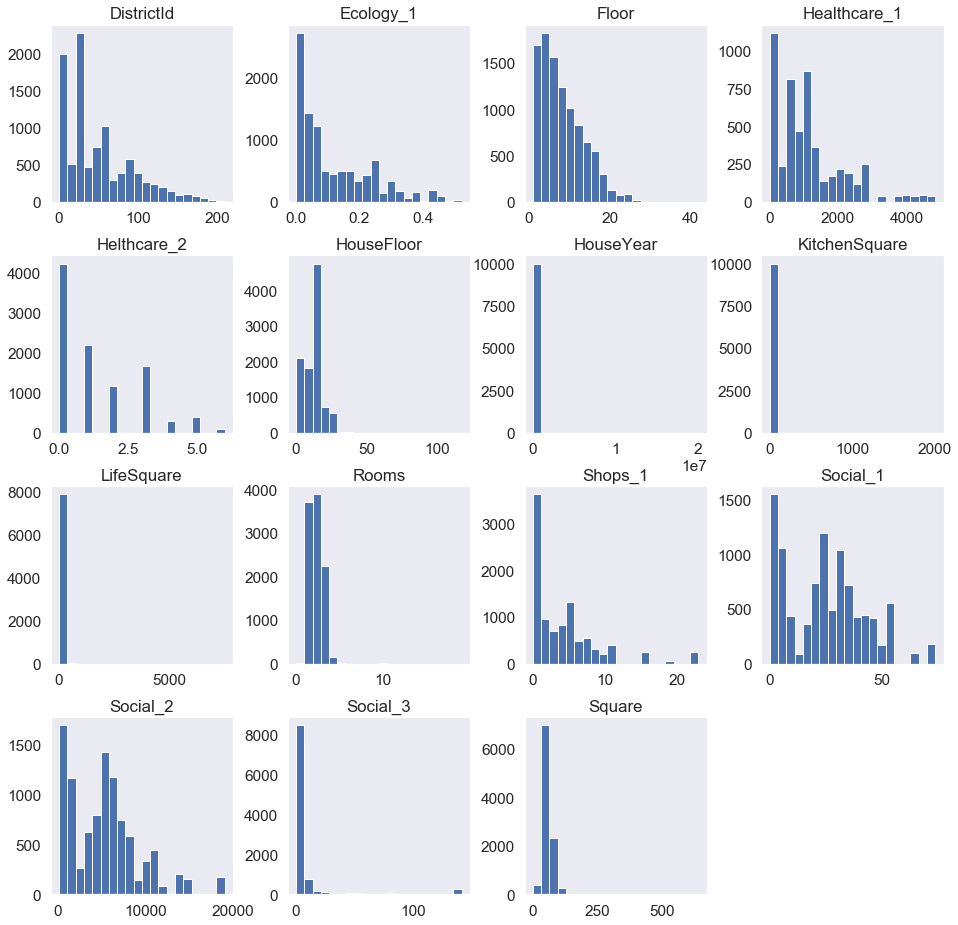

In [1234]:
X.hist(figsize=(16,16), bins=20, grid=False);

<Figure size 1152x576 with 0 Axes>

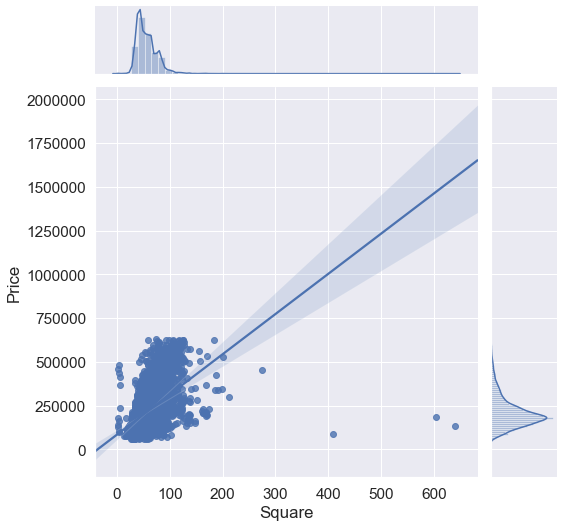

In [1147]:
plt.figure(figsize = (16, 8))

grid = sns.jointplot(X['Square'], y['Price'], kind='reg')
# plt.plot(np.arange(0, 8000, 100), np.arange(0, 8000, 100), color = 'red', linestyle='--')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

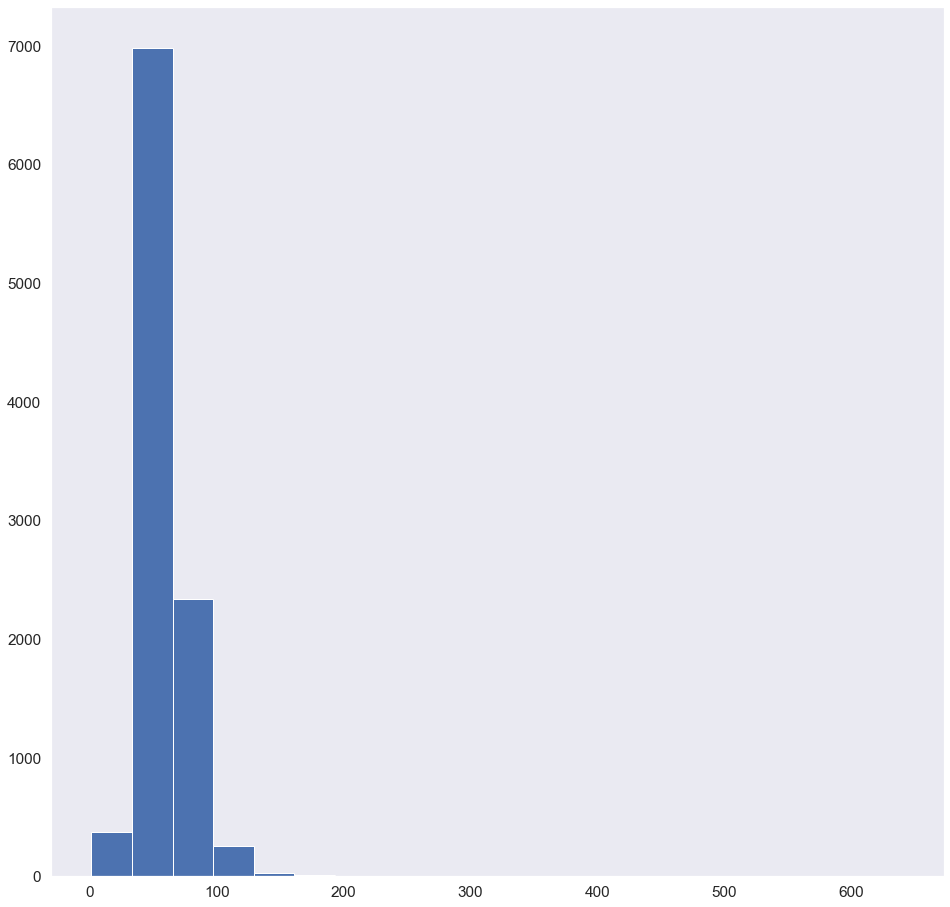

In [1148]:
X['Square'].hist(figsize=(16,16), bins=20, grid=False);

In [1149]:
plt.figure(figsize = (16, 8))

grid = sns.jointplot(X['Comb_eco2_eco3_shop2'], y['Price'], kind='reg')
# plt.plot(np.arange(0, 8000, 100), np.arange(0, 8000, 100), color = 'red', linestyle='--')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

KeyError: 'Comb_eco2_eco3_shop2'

<Figure size 1152x576 with 0 Axes>

In [ ]:
plt.figure(figsize = (16, 8))

grid = sns.jointplot(X['DistrictId'], X['Healthcare_1'], kind='reg')
# plt.plot(np.arange(0, 8000, 100), np.arange(0, 8000, 100), color = 'red', linestyle='--')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [ ]:
plt.figure(figsize = (16, 8))

grid = sns.jointplot(X['Ecology_1'], y['Price'], kind='reg')
# plt.plot(np.arange(0, 8000, 100), np.arange(0, 8000, 100), color = 'red', linestyle='--')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [ ]:
plt.figure(figsize = (16, 8))

grid = sns.jointplot(X['Social_1'], y['Price'], kind='reg')
# plt.plot(np.arange(0, 8000, 100), np.arange(0, 8000, 100), color = 'red', linestyle='--')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [ ]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = X.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

# Очистка данных

In [1372]:
index_list = X[X['Square'] > 300].index
X = X.drop(index_list)
y = y.drop(index_list)

In [1373]:
class FeatureImputer:
    """Заполнение пропусков и облработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
        self.med_HC1_by_district = X.groupby(['DistrictId'], as_index=False).agg({'Healthcare_1':'median'}).\
                                    rename(columns={'Healthcare_1':'MedHC_1ByDistr'})
    
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        #current_year = 2019
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        #X['Healthcare_1_nan'] = X['Healthcare_1'].isna() * 1
        #X.loc[X['Healthcare_1_nan'] == 1, 'Healthcare_1'] = self.medians['Healthcare_1']
        
        #if self.med_HC1_by_district is not None:
            #X = X.merge(self.med_HC1_by_district, on=['DistrictId'], how='left')
            #X.loc[X['Healthcare_1_nan'] == 1, 'Healthcare_1'] = X.loc[X['Healthcare_1_nan'] == 1,'MedHC_1ByDistr']
            #X = X.drop('MedHC1ByDistrict')
        
        #X['Healthcare_1_nan_2'] = X['Healthcare_1'].isna() * 1
        #X.loc[X['Healthcare_1_nan_2'] == 1, 'Healthcare_1'] = self.medians['Healthcare_1']
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[X['LifeSquare_nan'] == 1, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 1
        
        
        return X
    

In [1374]:
imputer = FeatureImputer()

imputer.fit(X)

X = imputer.transform(X)

imputer.fit(X_final)
X_final = imputer.transform(X_final)

X.shape

(9997, 21)

In [1375]:
X.isnull().sum()

DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Helthcare_2           0
Shops_1               0
Shops_2               0
Rooms_outlier         0
HouseFloor_outlier    0
HouseYear_outlier     0
LifeSquare_nan        0
dtype: int64

In [1376]:
X.shape

(9997, 21)

# Feture Eng

In [1377]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            
        ## square
        if y is not None:
            df['Price'] = y.values
            df = self.square_to_cat(df)
            self.med_price_by_square = df.groupby(['sq_cat'], as_index = False).agg({'Price':'median'}).\
                                        rename(columns={'Price':'MedPriceBySq'})
    
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_2'] = X['Ecology_2'].astype('int8')
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].astype('int8')
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].astype('int8')
        X['Comb_eco2_eco3_shop2'] = X['Ecology_2'] + X['Ecology_3'] + X['Shops_2']
        
        # More categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X) 
        X = self.square_to_cat(X)
        
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        if self.med_price_by_square is not None:
            X = X.merge(self.med_price_by_square, on=['sq_cat'], how='left')
            
        # Создать категориальный признак 
        #X['Social_1_category'] = (X['Social_1'] // 10 * 10).astype('category')

        # Feature embedding
        #mapping = X.groupby('Social_1_category')['Square'].mean().to_dict()
        #X['Sq_mean_by_S1_1_cat'] = X['Social_1_category'].map(mapping)
        
        #X['Sq_mean_by_S1_1_cat'] = X['Sq_mean_by_S1_1_cat'].astype('float64')
        #X['Sq_mean_by_S1_1_cat'] = X['Square'] - X['Sq_mean_by_S1_1_cat'] 
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
    
    @staticmethod
    def square_to_cat(X):
        X['sq_cat'] = np.nan
        
        #X.loc[X['Square'] < 25, 'sq_cat'] = 1
        #X.loc[(X['Square'] >= 25) & (X['Square'] < 50), 'sq_cat'] = 2
        #X.loc[(X['Square'] >= 50) & (X['Square'] < 75), 'sq_cat'] = 3
        #X.loc[(X['Square'] >= 75) & (X['Square'] < 100), 'sq_cat'] = 4
        #X.loc[(X['Square'] >= 100) & (X['Square'] < 125), 'sq_cat'] = 5
        #X.loc[(X['Square'] >= 125), 'sq_cat'] = 6
        
        X.loc[X['Square'] < 25, 'sq_cat'] = 1
        X.loc[(X['Square'] >= 25) & (X['Square'] < 40), 'sq_cat'] = 2
        X.loc[(X['Square'] >= 40) & (X['Square'] < 60), 'sq_cat'] = 3
        X.loc[(X['Square'] >= 60) & (X['Square'] < 80), 'sq_cat'] = 4
        X.loc[(X['Square'] >= 80) & (X['Square'] < 100), 'sq_cat'] = 5
        X.loc[(X['Square'] >= 100) & (X['Square'] < 126), 'sq_cat'] = 6
        X.loc[(X['Square'] >= 125), 'sq_cat'] = 7
        
        return X

        
            
    

In [1378]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [1347]:
X['Sq_mean_by_S1_1_cat'].describe()

KeyError: 'Sq_mean_by_S1_1_cat'

In [1265]:
X['Sq_mean_by_S1_1_cat'] = X['Sq_mean_by_S1_1_cat'].astype('float64')

In [1269]:
X_final['Sq_mean_by_S1_1_cat'] = X_final['Sq_mean_by_S1_1_cat'].astype('float64')

In [1270]:
X_final['Sq_mean_by_S1_1_cat'] = X_final['Square'] - X_final['Sq_mean_by_S1_1_cat']

In [1348]:
X.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2',
       'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier',
       'LifeSquare_nan', 'DistrictId_count', 'new_district',
       'Comb_eco2_eco3_shop2', 'floor_cat', 'year_cat', 'sq_cat',
       'MedPriceByDistrict', 'MedPriceByFloorYear', 'MedPriceBySq'],
      dtype='object')

In [1379]:
scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))

sub_fr = X[['Social_1','Social_2']].copy()
sub_fr_final = X_final[['Social_1','Social_2']].copy()

colnames = sub_fr.columns
sf_train_scaled = pd.DataFrame(scaler.fit_transform(sub_fr), columns=colnames)
sf_test_scaled = pd.DataFrame(scaler.transform(sub_fr_final), columns=colnames) # НЕ обучаемся на тесте!

sf_train_scaled.head(2)

,Social_1,Social_2
0,0.266667,0.475190
1,0.700000,0.887162


In [1380]:
dim_reducer1d, components_1d = reduce_dims(sf_train_scaled, dims=1, method='pca')


comp_1d_final = dim_reducer1d.transform(sf_test_scaled)

components_1d.head(2)

,component_1
0,0.534033
1,1.127315


In [1381]:
X['comp_1'] = components_1d['component_1']
X_final['comp_1'] = comp_1d_final

In [1382]:
X.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2',
       'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier',
       'LifeSquare_nan', 'DistrictId_count', 'new_district',
       'Comb_eco2_eco3_shop2', 'floor_cat', 'year_cat', 'sq_cat',
       'MedPriceByDistrict', 'MedPriceByFloorYear', 'MedPriceBySq', 'comp_1'],
      dtype='object')

# Построение модели

In [359]:
# Удаляю, просто чтобы было быстрее строить модель. Возможно, вам стоит что-то сделать с не количественными признаками
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                  'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan',
                   'HouseFloor', 'HouseYear', 'Healthcare_1', 'Healthcare_1_nan', 'Helthcare_2',
                   
                  'DistrictId_count', 'new_district', 'Ecology_2', 'Ecology_3', 'Shops_2',
                  'MedPriceByDistrict',
                  'MedPriceByFloorYear',
                  'MedPriceBySq']

X = X[remain_features]
X_final = X_final[remain_features]

In [1359]:
drop_features = ['floor_cat', 'year_cat', 'Ecology_3', 'Ecology_2']
X = X.drop(drop_features, axis = 1)
X_final = X_final.drop(drop_features, axis=1)
X.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Rooms_outlier',
       'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan',
       'DistrictId_count', 'new_district', 'Comb_eco2_eco3_shop2', 'sq_cat',
       'MedPriceByDistrict', 'MedPriceByFloorYear', 'MedPriceBySq', 'comp_1'],
      dtype='object')

In [1363]:
drop_features = ['Social_1', 'Social_2']
X = X.drop(drop_features, axis = 1)
X_final = X_final.drop(drop_features, axis=1)
X.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_3', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Rooms_outlier', 'HouseFloor_outlier',
       'HouseYear_outlier', 'LifeSquare_nan', 'DistrictId_count',
       'new_district', 'Comb_eco2_eco3_shop2', 'sq_cat', 'MedPriceByDistrict',
       'MedPriceByFloorYear', 'MedPriceBySq', 'comp_1'],
      dtype='object')

In [1051]:
drop_features = ['comp_1_sq', 'MedPriceBySq', 'sq_cat']
X = X.drop(drop_features, axis = 1)
X_final = X_final.drop(drop_features, axis=1)
X.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_3', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Rooms_outlier', 'HouseFloor_outlier',
       'HouseYear_outlier', 'LifeSquare_nan', 'DistrictId_count',
       'new_district', 'Comb_eco2_eco3_shop2', 'MedPriceByDistrict',
       'MedPriceByFloorYear', 'comp_1'],
      dtype='object')

In [1385]:
lgb_model = LGBMRegressor(criterion='mse',
                            min_samples_leaf=10,
                            random_state=42 #,
                         
                         # n_estimators=100,
                         # max_depth=7
                         
                         )

params = {'n_estimators':range(100, 300, 10), 
          'max_depth':range(3, 20, 2)}

gs = GridSearchCV(lgb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=42, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков 
                 )
gs.fit(X, y)  # НА TRAIN!

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, criterion='mse',
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001,
                                     min_samples_leaf=10, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': r

In [1386]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 260}

In [1383]:
model = LGBMRegressor(max_depth=5,
                             min_samples_leaf=10,
                             n_estimators=260,
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.751 +- 0.016


In [1387]:
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=10,
              min_split_gain=0.0, n_estimators=260, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

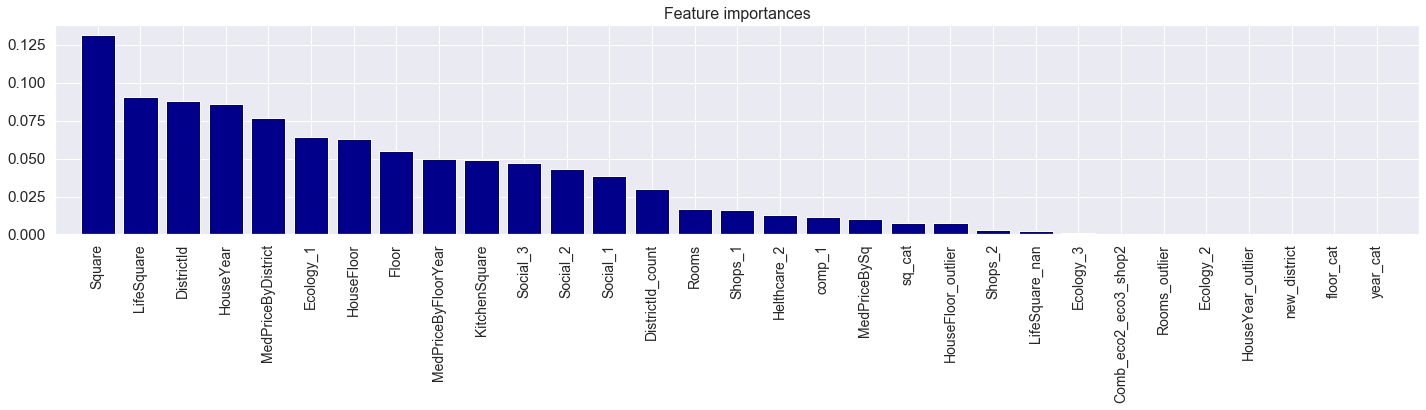

In [1388]:
plot_feature_importances(importances = model.feature_importances_, X=X)

In [1389]:
y_pred_final = model.predict(X_final)

preds_final = pd.DataFrame()
preds_final['Id'] = final_index_list
preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,155775.742762
1,15856,228996.942389
2,5480,289924.663235
3,15664,319303.544211
4,14275,141421.659362
